In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from scipy.optimize import curve_fit

plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [2]:
sim_time = 16 * 2*np.pi

Nmax = 10
nu = 1.
Delta = 1.
kappa = .1

In [3]:
def get_pops(t, Gamma):
    H = Delta/2 * tensor(sigmax(), qeye(Nmax))
    H += kappa/2 * tensor(sigmaz(), (destroy(Nmax) + create(Nmax)))  
    H += nu * tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    init_state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, 0.))
    e_op = tensor(ket2dm(basis(2,0)), qeye(Nmax))
    c_op = np.sqrt(Gamma) * tensor(qeye(2), create(Nmax) * destroy(Nmax))
    
    result = mesolve(H, init_state, t, e_ops=[e_op], c_ops=[c_op])
    return result.expect[0]

In [4]:
def get_pops_trot(Gamma, trot_steps, seed):
    np.random.seed(seed)
    
    H_base = Delta/2 * tensor(sigmax(), qeye(Nmax))
    H_base += kappa/2 * tensor(sigmaz(), (destroy(Nmax) + create(Nmax))) 
    
    detuning_std = np.sqrt(Gamma / sim_time * trot_steps)
    nu_list = np.random.normal(scale=detuning_std, size=trot_steps) + nu

    tlist = np.linspace(0, sim_time, trot_steps+1)
    state = tensor(ket2dm(basis(2,0)), thermal_dm(Nmax, 0.))
    e_op = tensor(ket2dm(basis(2,0)), qeye(Nmax))
    pops = [1.]
    for i in range(trot_steps):
        tlist_cur = tlist[i:i+2]
        nu_cur = nu_list[i]
        H = H_base + nu_cur * tensor(qeye(2), create(Nmax) * destroy(Nmax))
        state = mesolve(H, state, tlist_cur).states[-1]
        pops += [np.real((e_op * state).tr())]
    
    return np.array(pops)

In [5]:
Gamma = 0.4
steps = 160
pops_sim = get_pops(np.linspace(0, sim_time, steps+1), Gamma)

trot_steps = 160
pops_trot = np.load('./data/stotest_Gamma=%.2f_trot%d.npy'%(Gamma, trot_steps))
print(pops_trot.shape[0])

2000


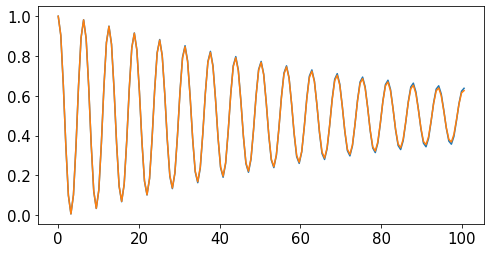

In [6]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.linspace(0, sim_time, steps+1), pops_sim)
ax.plot(np.linspace(0, sim_time, trot_steps+1), np.mean(pops_trot, axis=0))

# Vary number of trials (batch size)

Std is over 2000 / (# trials) sets. Shot noise is ignored.

In [7]:
trot_steps = 160
Gamma_list = [0.05, 0.15, 0.25, 0.4]
batch_size_list = [20, 50, 100, 200]

Gamma_mean_list = np.zeros((len(Gamma_list), len(batch_size_list)))
Gamma_std_list = np.zeros((len(Gamma_list), len(batch_size_list)))

for i in range(len(Gamma_list)):
    Gamma = Gamma_list[i]
    pops_trot = np.load('./data/stotest_Gamma=%.2f_trot%d.npy'%(Gamma, trot_steps))    
    for j in range(len(batch_size_list)):
        batch_size = batch_size_list[j]
        num_batch = pops_trot.shape[0] // batch_size
        print('Gamma: ', Gamma, ' batch size: ', batch_size)
        
        fitted_Gamma_list = []
        for k in tqdm(range(num_batch)):
            pops_batch = np.mean(pops_trot[batch_size*k:batch_size*(k+1), :], axis=0)
            popt, pcov = curve_fit(get_pops, np.linspace(0, sim_time, trot_steps+1), pops_batch, p0=[Gamma])
            fitted_Gamma_list += [popt[0]]
            
        Gamma_mean_list[i,j] = np.mean(fitted_Gamma_list)
        Gamma_std_list[i,j] = np.std(fitted_Gamma_list)

Gamma:  0.05  batch size:  20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Gamma:  0.05  batch size:  50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:43<00:00,  1.10s/it]


Gamma:  0.05  batch size:  100


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]


Gamma:  0.05  batch size:  200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]


Gamma:  0.15  batch size:  20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


Gamma:  0.15  batch size:  50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:53<00:00,  1.33s/it]


Gamma:  0.15  batch size:  100


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.45s/it]


Gamma:  0.15  batch size:  200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]


Gamma:  0.25  batch size:  20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Gamma:  0.25  batch size:  50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:02<00:00,  1.56s/it]


Gamma:  0.25  batch size:  100


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]


Gamma:  0.25  batch size:  200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.30s/it]


Gamma:  0.4  batch size:  20


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:41<00:00,  2.21s/it]


Gamma:  0.4  batch size:  50


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:19<00:00,  2.00s/it]


Gamma:  0.4  batch size:  100


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.71s/it]


Gamma:  0.4  batch size:  200


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]


In [8]:
print(Gamma_mean_list)
print(Gamma_std_list)

[[0.05135549 0.05105529 0.05096526 0.05086448]
 [0.1518433  0.1506438  0.14988028 0.14946952]
 [0.24975014 0.24661072 0.24529734 0.24461752]
 [0.39363661 0.38662486 0.38520819 0.38397018]]
[[0.00958757 0.00670103 0.00539757 0.00354842]
 [0.02807076 0.0198225  0.01305441 0.00683788]
 [0.04971193 0.03093961 0.02028774 0.01106221]
 [0.08023603 0.04527241 0.03483333 0.02207796]]


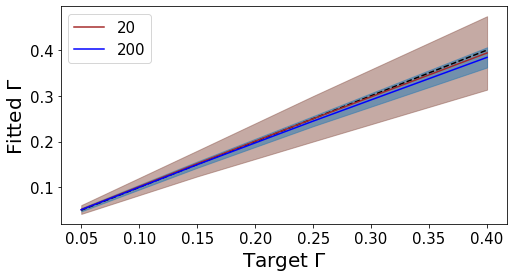

In [18]:
Gamma_mean_list = np.array([[0.05135549, 0.05105529, 0.05096526, 0.05086448],
                            [0.1518433,  0.1506438,  0.14988028, 0.14946952],
                            [0.24975014, 0.24661072, 0.24529734, 0.24461752],
                            [0.39363661, 0.38662486, 0.38520819, 0.38397018]])
Gamma_std_list = np.array([[0.00958757, 0.00670103, 0.00539757, 0.00354842],
                           [0.02807076, 0.0198225,  0.01305441, 0.00683788],
                           [0.04971193, 0.03093961, 0.02028774, 0.01106221],
                           [0.08023603, 0.04527241, 0.03483333, 0.02207796]])

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(Gamma_list, Gamma_list, '--', color='k')
ax.plot(Gamma_list, Gamma_mean_list[:,0], '-', color='brown', label='20')
ax.fill_between(Gamma_list, 
                Gamma_mean_list[:,0] - Gamma_std_list[:,0], 
                Gamma_mean_list[:,0] + Gamma_std_list[:,0], color='tab:brown', alpha=0.5)
ax.plot(Gamma_list, Gamma_mean_list[:,3], '-', color='blue', label='200')
ax.fill_between(Gamma_list, 
                Gamma_mean_list[:,3] - Gamma_std_list[:,3], 
                Gamma_mean_list[:,3] + Gamma_std_list[:,3], color='tab:blue', alpha=0.5)
ax.legend();
ax.set_xlabel('Target '+r'$\Gamma$')
ax.set_ylabel('Fitted '+r'$\Gamma$');

# Use all 2000 random seeds, vary number of Trotter steps

Std is over shot noise. Here I assume 1 shot per each random seed. This way, the number of shots is the same as our experiment, which uses 20 random seeds, each with 100 shots. 

In [7]:
Gamma_list = [0.05, 0.15, 0.25, 0.4, 1.]
trot_steps_list = [160, 320, 640]
trials = 100

Gamma_mean_list = np.zeros((len(Gamma_list), len(trot_steps_list)))
Gamma_std_list = np.zeros((len(Gamma_list), len(trot_steps_list)))
Gamma_avg_fitstd_list = np.zeros((len(Gamma_list), len(trot_steps_list)))

for i in range(len(Gamma_list)):
    Gamma = Gamma_list[i]
    
    for j in range(len(trot_steps_list)):
        trot_steps = trot_steps_list[j]
        print('Gamma: ', Gamma, ' trot steps: ', trot_steps)
    
        pops_trot = np.load('./data/stotest_Gamma=%.2f_trot%d.npy'%(Gamma, trot_steps)) 
        fitted_Gamma_list = []

        fitstd_list = []
        for k in tqdm(range(trials)):
            np.random.seed(k)    

            pops_shot = np.zeros(trot_steps + 1)        
            for l in range(pops_trot.shape[0]):        
                pops_shot = pops_shot + np.random.binomial(1, p=pops_trot[l,:])
            pops_shot = pops_shot / pops_trot.shape[0]

            popt, pcov = curve_fit(get_pops, np.linspace(0, sim_time, trot_steps+1), pops_shot, p0=[Gamma])
            fitted_Gamma_list += [popt[0]]
            
            fitstd_list += [np.sqrt(pcov[0,0])]
            
        Gamma_mean_list[i,j] = np.mean(fitted_Gamma_list)
        Gamma_std_list[i,j] = np.std(fitted_Gamma_list)
        avg_fitstd_list[i,j] = np.mean(fitstd_list)

Gamma:  0.05  trot steps:  160


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


Gamma:  0.05  trot steps:  320


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Gamma:  0.05  trot steps:  640


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


Gamma:  0.15  trot steps:  160


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


Gamma:  0.15  trot steps:  320


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


Gamma:  0.15  trot steps:  640


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


Gamma:  0.25  trot steps:  160


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


Gamma:  0.25  trot steps:  320


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


Gamma:  0.25  trot steps:  640


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


Gamma:  0.4  trot steps:  160


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:44<00:00,  1.65s/it]


Gamma:  0.4  trot steps:  320


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:09<00:00,  1.89s/it]


Gamma:  0.4  trot steps:  640


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


Gamma:  1.0  trot steps:  160


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:02<00:00,  4.83s/it]


Gamma:  1.0  trot steps:  320


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:06<00:00,  4.27s/it]


Gamma:  1.0  trot steps:  640


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:34<00:00,  4.54s/it]


In [8]:
print(Gamma_mean_list)
print(Gamma_std_list)
print()

[[0.05088084 0.05057435 0.05116115]
 [0.14937054 0.15135512 0.15265367]
 [0.24432909 0.24717451 0.25210397]
 [0.38325693 0.39189795 0.39731184]
 [0.99756227 0.92781897 0.98355203]]
[[0.00039843 0.00033086 0.00024847]
 [0.00105382 0.00077786 0.00049844]
 [0.0013503  0.00119639 0.00076843]
 [0.0029287  0.00179142 0.00127619]
 [0.01580211 0.00729056 0.00663937]]


Text(0, 0.5, 'Fitted $\\Gamma$')

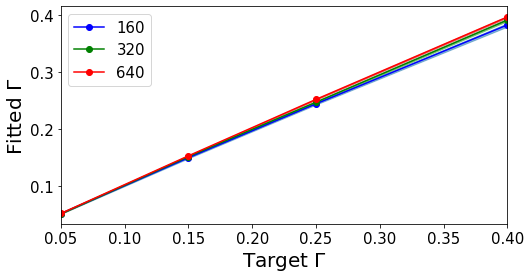

In [3]:
Gamma_mean_list = np.array([[0.05088084, 0.05057435, 0.05116115],
                            [0.14937054, 0.15135512, 0.15265367],
                            [0.24432909, 0.24717451, 0.25210397],
                            [0.38325693, 0.39189795, 0.39731184]])
Gamma_std_list = np.array([[0.00039843, 0.00033086, 0.00024847],
                           [0.00105382, 0.00077786, 0.00049844],
                           [0.0013503,  0.00119639, 0.00076843],
                           [0.0029287,  0.00179142, 0.00127619]])
Gamma_list = [0.05, 0.15, 0.25, 0.4]
trot_steps_list = [160, 320, 640]

color_list = ['blue', 'green', 'red']
fig, ax = plt.subplots(figsize=(8,4))
for i in range(len(trot_steps_list)):
    ax.plot(Gamma_list, Gamma_mean_list[:,i], '.-', ms=12, color=color_list[i], label=str(trot_steps_list[i]))
    ax.fill_between(Gamma_list,
                    Gamma_mean_list[:,i] - Gamma_std_list[:,i],
                    Gamma_mean_list[:,i] + Gamma_std_list[:,i], color='tab:'+color_list[i], alpha=0.5)
ax.legend();
ax.set_xlim((0.05, 0.4))
ax.set_xlabel('Target '+r'$\Gamma$')
ax.set_ylabel('Fitted '+r'$\Gamma$')

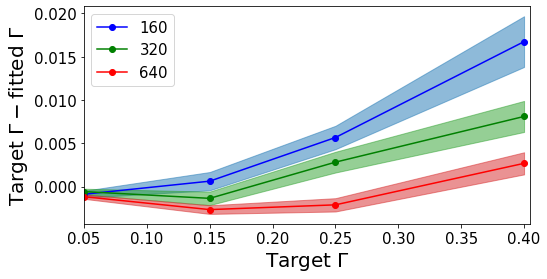

In [4]:
fig, ax = plt.subplots(figsize=(8,4))
for i in range(len(trot_steps_list)):
    ax.plot(Gamma_list, Gamma_list - Gamma_mean_list[:,i], '.-', ms=12, color=color_list[i], label=str(trot_steps_list[i]))
    ax.fill_between(Gamma_list,
                    Gamma_list - Gamma_mean_list[:,i] - Gamma_std_list[:,i],
                    Gamma_list - Gamma_mean_list[:,i] + Gamma_std_list[:,i], color='tab:'+color_list[i], alpha=0.5)
ax.legend();
ax.set_xlim((0.05, 0.405))
ax.set_xlabel('Target '+r'$\Gamma$')
ax.set_ylabel('Target '+r'$\Gamma - $'+'fitted '+r'$\Gamma$');

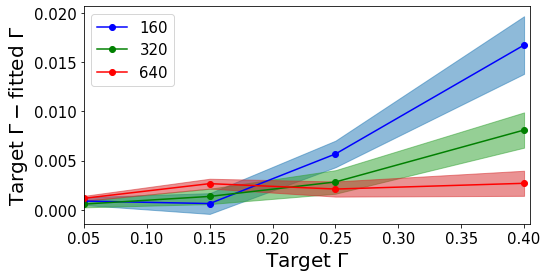

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
for i in range(len(trot_steps_list)):
    ax.plot(Gamma_list, np.abs(Gamma_list - Gamma_mean_list[:,i]), '.-', ms=12, color=color_list[i], label=str(trot_steps_list[i]))
    ax.fill_between(Gamma_list,
                    np.abs(Gamma_list - Gamma_mean_list[:,i]) - Gamma_std_list[:,i],
                    np.abs(Gamma_list - Gamma_mean_list[:,i]) + Gamma_std_list[:,i], color='tab:'+color_list[i], alpha=0.5)
ax.legend();
ax.set_xlim((0.05, 0.405))
ax.set_xlabel('Target '+r'$\Gamma$')
ax.set_ylabel('Target '+r'$\Gamma - $'+'fitted '+r'$\Gamma$');